Notebook Testing

In [27]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
from photutils.aperture import aperture_photometry, CircularAperture
from photutils import centroids
#%matplotlib inline

#plt.style.use(r"C:\Users\Sam Whitebook\Documents\GitHub\LocalTestRepository\Phys240.mplstyle")

In [28]:
files = sorted(glob.glob("F:/SDI/sec17/*.fz"))
#files = sorted(glob.glob("/Users/lucaangeleri/Documents/LCO/sec31small/*"))
print(len(files))
hdus = [fits.open(f) for f in files] #opens fits files so we can access header data
data = [h[1].data for h in hdus] #array for image data
try:
    aligned = [aa.register(i, data[0])[0] for i in data[0:]]
except:
    aligned = data
    print("DID NOT ALIGN")
template = np.mean(aligned, axis = 0)
bkg_phot = sep.Background(template)
extracted_phot = sep.extract(template - bkg_phot.back(),  bkg_phot.globalrms*3, minarea =25, segmentation_map=False) #find sources in image

w = WCS(hdus[0][1].header) #WCS matrix object

100


Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


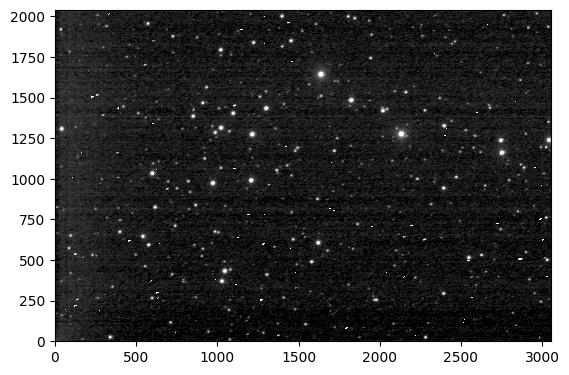

In [29]:
plt.imshow(template, cmap = 'gray', norm = LogNorm(vmin = 1, vmax = 75), origin = "lower")
plt.show()

In [30]:
references = []
mags = []
for src in extracted_phot: #indexes extracted sources by try number to find reference stars
    x = src['x']
    y = src['y']
    coord = pixel_to_skycoord(x, y, w).transform_to('icrs')
    search = SDSS.query_crossid(coord, fields = ['ra', 'dec', 'psfMag_g', 'psfMagErr_g'], radius = 15 * u.arcsec, region = False)
    if search: #if SDSS query returned results, continue
        if search['psfMag_g'] < 16 and search['type'] == 'STAR':
            ref = dict(ra = search['ra'], dec = search['dec'], x_coord = x, y_coord = y, x_min = src['xmin'], x_max = src['xmax'], g_mag = search['psfMag_g'], g_mag_err = search['psfMagErr_g'])
            references.append(ref)

for ref in references:
        coords = [ref['x_coord'], ref['y_coord']]
        radius = ( (ref['x_max'] - ref['x_min']) / 2 )
        app = CircularAperture(coords, radius) # takes instrumental mag at point
        app_phot = aperture_photometry(template - bkg_phot.back(), app)
        inst_mag = -2.5 * np.log10(float(app_phot['aperture_sum']))
        mag_cat = dict(inst_mag = inst_mag, inst_err = None, sky_mag = float(ref['g_mag']), sky_err = float(ref['g_mag_err'])) #Leaving an empty keyword for instrumental error calculated later
        mags.append(mag_cat)

14.743172765957434
first try: [ 0.85187371 22.32842252]
second try: [ 0.92036514 22.8769601 ]


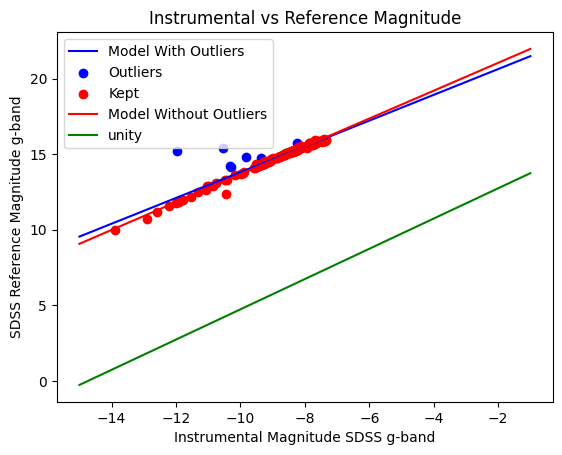

In [31]:
inst_mags = [mag['inst_mag'] for mag in mags]
sky_mags = [mag['sky_mag'] for mag in mags]
res = []


#Makes linear model for calibration:
p0 = np.polyfit(inst_mags, sky_mags, deg = 1)
x = np.arange(-15, 0)
y = p0[0]*x + p0[1]
plt.plot(x, y, color = 'b', label = "Model With Outliers")
diffs = [s['sky_mag']- (s['inst_mag']*p0[0] + p0[1]) for s in mags]
stdv = np.std(diffs)

inst_mags_final = []
sky_mags_final = []
outlier_inst =[]
outlier_sky =[]

for diff in diffs:
    if diff < stdv:
        i = diffs.index(diff)
        inst_mags_final.append(inst_mags[i])
        sky_mags_final.append(sky_mags[i])
    else:
        i = diffs.index(diff)
        outlier_inst.append(inst_mags[i])
        outlier_sky.append(sky_mags[i])
p1 = np.polyfit(inst_mags_final, sky_mags_final, deg = 1)
p2 = np.polyfit(inst_mags_final, sky_mags_final, deg = 0)
print(p2[0])
print("first try: {}".format(p0))
print("second try: {}".format(p1))


plt.scatter(outlier_inst, outlier_sky, color = 'b', label = "Outliers")
plt.scatter(inst_mags_final, sky_mags_final, color = 'r', label = "Kept")
plt.plot(x, [i*p1[0] + p1[1] for i in x], color = 'r', label = "Model Without Outliers")
plt.plot(x, [i+ p2[0] for i in x], color = 'g', label = "unity")
plt.xlabel("Instrumental Magnitude SDSS g-band")
plt.ylabel("SDSS Reference Magnitude g-band")
plt.title("Instrumental vs Reference Magnitude")
plt.legend()
plt.savefig("F:/SDI/Section32Figures/calibrationplot.png", dpi = 1000)
plt.show()



In [52]:

mags_final = []
for i, image in enumerate(aligned):
    print(i)
    N_r = hdus[i][1].header["RDNOISE"] #readout noise
    e = 1 #Telescope efficiency, taken to be .5 for now BUT ASK ABOUT IT
    Q_e = 1 #quantum efficency of SBIG STL 6303 cameras used at LCO .4m telescopes
    A = 1250 #.4m diameter telescope area in cm^2. Way to not hardcode telescope area?
    A_e = A*e*Q_e
    i_DC = hdus[i][1].header["DARKCURR"] #dark current reported in header
    t = hdus[i][1].header["EXPTIME"] #actual exposure time
    Omega = hdus[i][1].header["PIXSCALE"]
    #print(N_r, i_DC, t, Omega)
    for c, source in enumerate(extracted_phot):
        coords = [source['x'], source['y']]
        radius_i = (source['xmax'] - source['xmin']) / 2
        radius_o = radius_i + 20
        app_i = CircularAperture(coords, radius_i)
        app_o = CircularAperture(coords, radius_o)
        app_phot_i = aperture_photometry(image, app_i)
        app_phot_o = aperture_photometry(image, app_o)
        flux = app_phot_i['aperture_sum'][0] - ((radius_i/radius_o)**2)*app_phot_o['aperture_sum'][0]
        flux_area = flux/(np.pi*(radius_i**2))
        flux_back = (app_phot_o['aperture_sum'][0]-app_phot_i['aperture_sum'][0])/(np.pi*((radius_o**2)-(radius_i**2)))
        #print(flux_back)
        if flux <= 0:
            inst_mag = 0 # need a better way to handle this
            delta_m = .3
            mag_coor = p1[0] * inst_mag + p1[1]
        else:
            inst_mag = -2.5*np.log10(flux)
            mag_coor = p1[0] * inst_mag + p1[1]
            N_t = flux_area*A_e + i_DC + flux_back*A_e*Omega
            S_N = (flux_area*A_e*t)/(((N_r**2)+(t*N_t))**(1/2))
            delta_m = 1.1/S_N
            print(S_N, delta_m, N_t, flux_area, flux_back)
        info = dict(source_id = c, corrected_mag = mag_coor, mag_error = delta_m, x = source['x'], y = source['y'])
        mags_final.append(info)

#print(mags_final)



0
443.9276710377832 0.0024778811319161446 22110.787104779705 16.759554937420713 1.601853011039742
361.479988115311 0.0030430453584310273 15440.03833549649 11.406338925062084 1.630503005750189
410.67960068818405 0.002678487069132988 19175.04546573199 14.439470685523741 1.5526994604514677
290.24304337054633 0.003789927183872781 10412.802782185236 7.523620340496669 1.3907273883646885
511.7129295375769 0.002149642771375827 29258.988171340294 22.220482646955016 2.0460480864089976
681.8033635973178 0.0016133683972988945 49374.988307822234 38.45441034506134 1.8027246572352558
575.9813834168231 0.0019097839473119882 35657.7347511663 27.60925006584562 1.5809271294610694
372.26468239909724 0.002954886810403123 14776.140202832546 11.491679697233133 0.5676421810912151
374.41732873790386 0.0029378982102882634 15963.46017234329 12.012891089729965 1.3066845657666681
374.1308023417401 0.002940148186449598 16405.307346169517 12.168470477857415 1.6478886191003403
256.5252869659241 0.004288076286787743 8

349


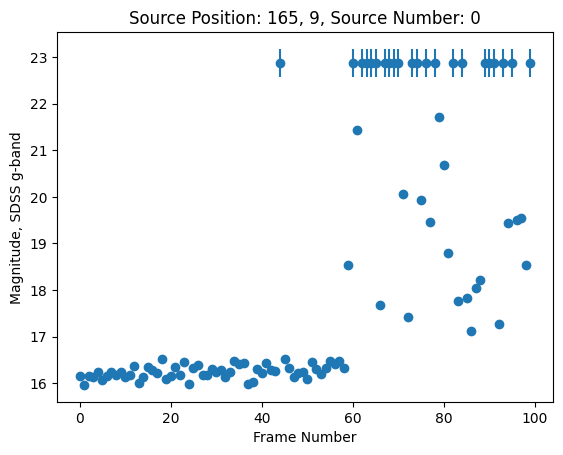

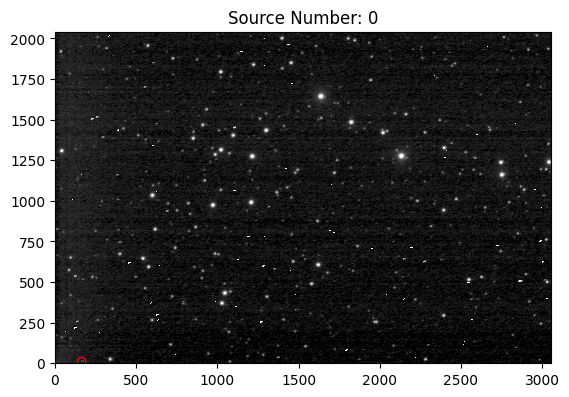

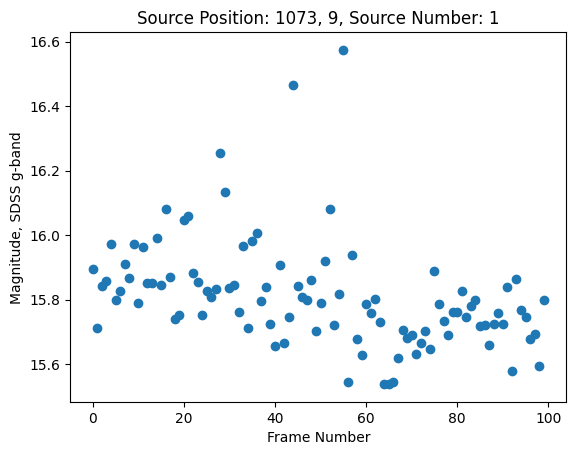

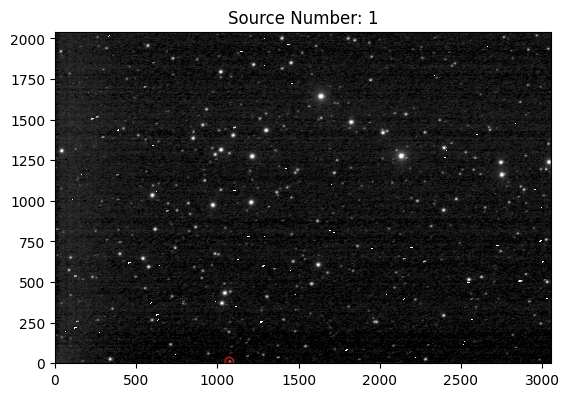

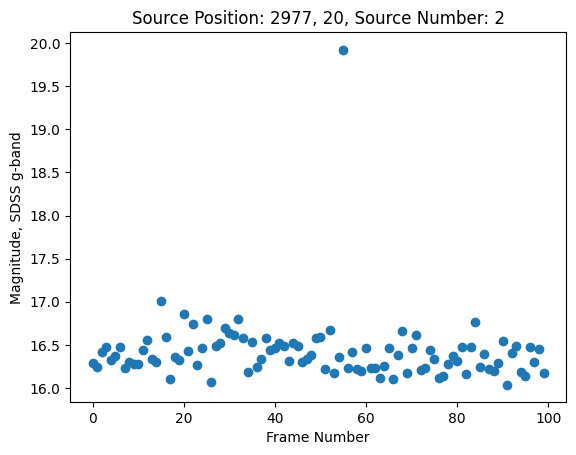

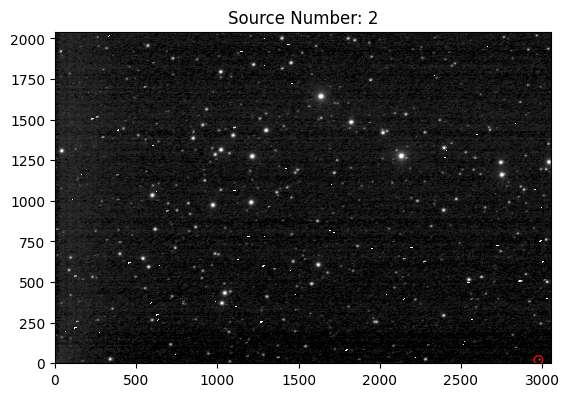

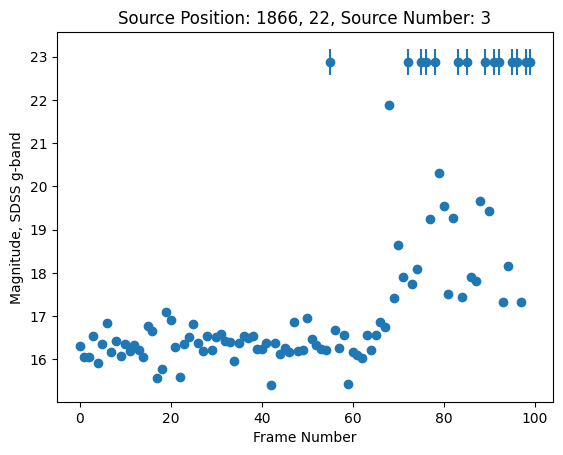

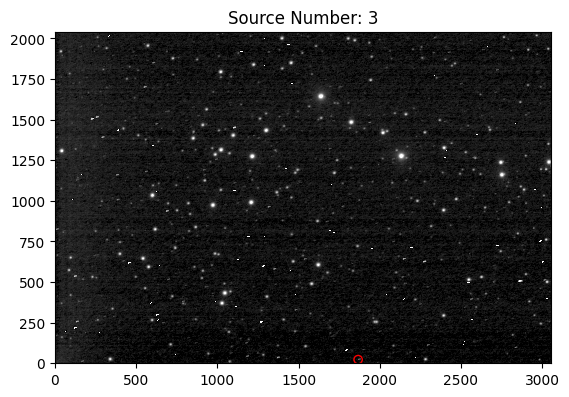

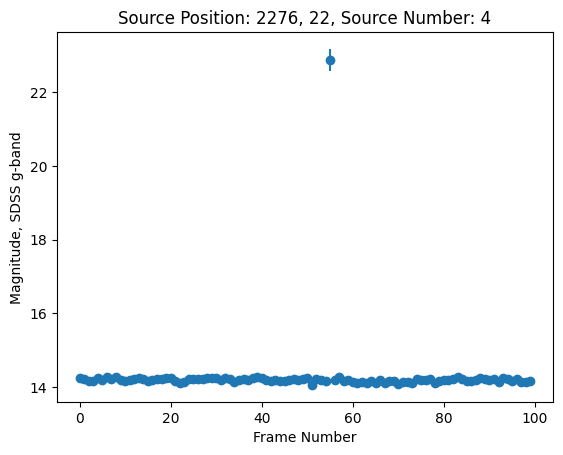

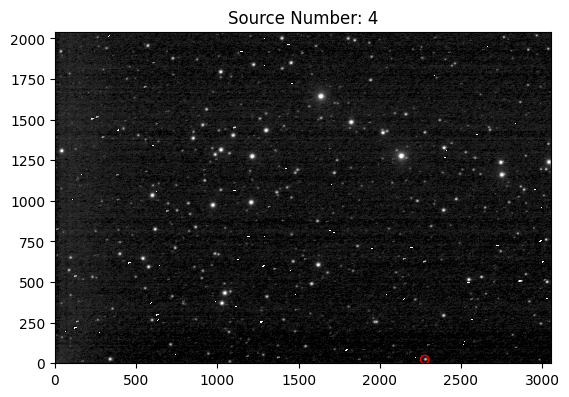

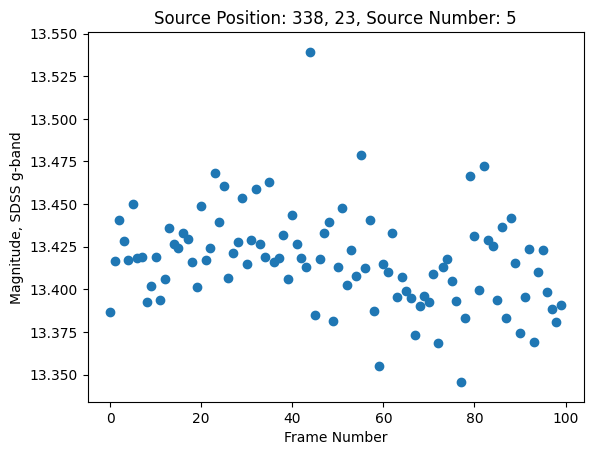

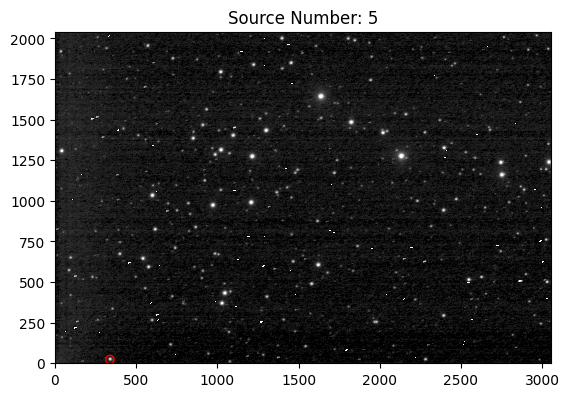

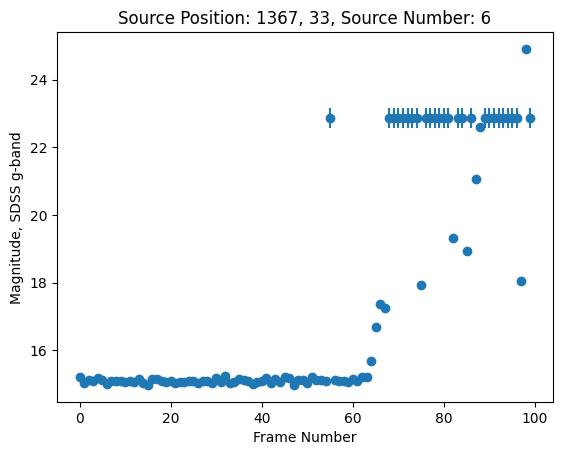

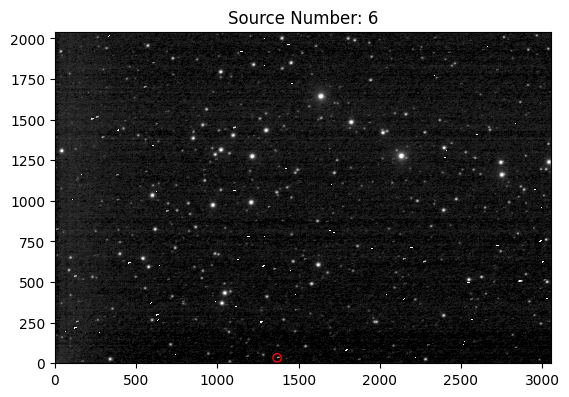

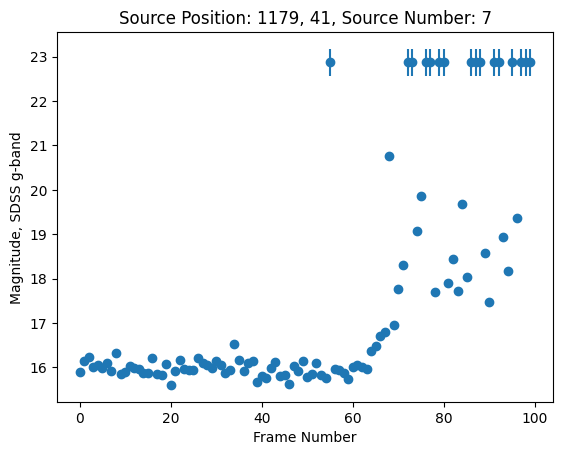

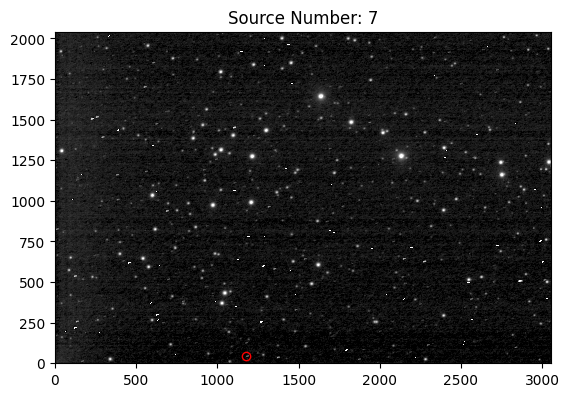

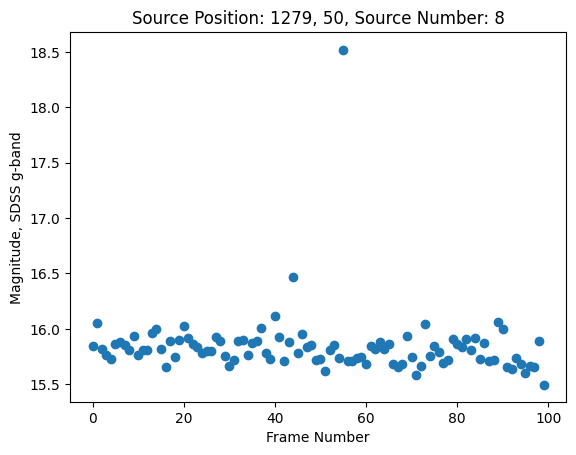

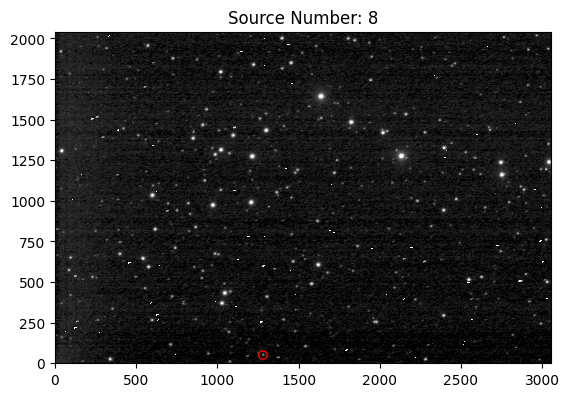

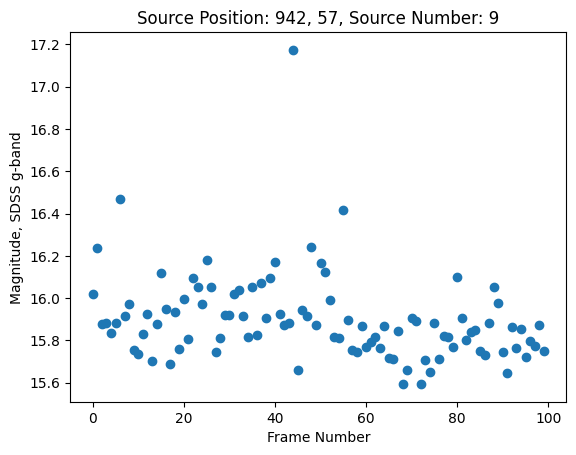

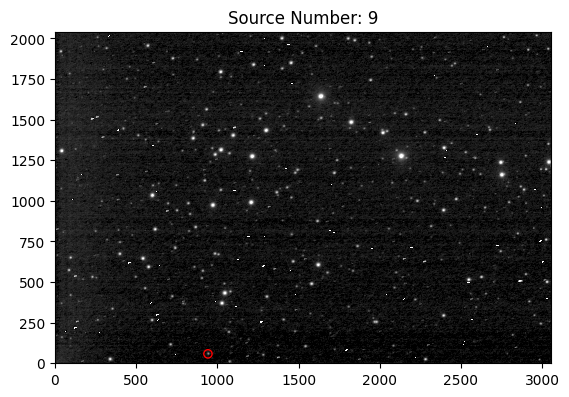


KeyboardInterrupt



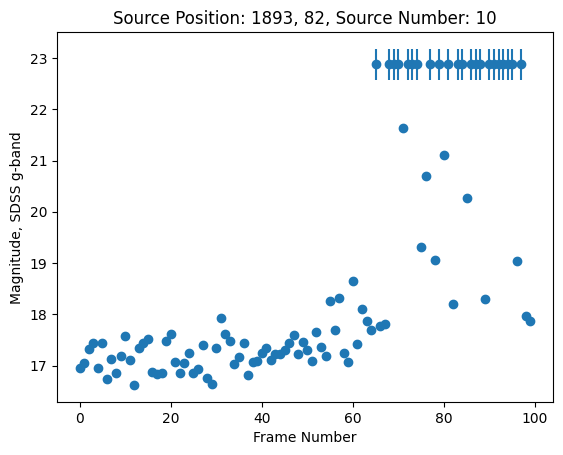

In [51]:
c = 0
x_b = data[0].shape[1]
y_b = data[0].shape[0]
print(len(extracted_phot))
while c != len(extracted_phot):
    Mags = []
    for mag in mags_final:
        if mag['source_id'] == c:
            Mags.append(mag)
    r = np.arange(0, len(Mags), 1)
    #plt.scatter(r, [m['corrected_mag'] for m in Mags], color = 'b')
    plt.errorbar(r, [m['corrected_mag'] for m in Mags], yerr= [m['mag_error'] for m in Mags], linestyle = 'none', marker = 'o')
    i = 0
    if abs(x_b - Mags[0]['x']) < 50 or abs(0-Mags[0]['x']) < 50:
        if abs(y_b - Mags[0]['y']) < 50 or abs(0-Mags[0]['y']) < 50:
            print("Border Warning")
    plt.title("Source Position: {}, {}, Source Number: {}".format(int(Mags[0]['x']), int(Mags[0]['y']), c))
    plt.xlabel('Frame Number')
    plt.ylabel("Magnitude, SDSS g-band")

    #plt.ylim(0, 25)
    #plt.figure(dpi=300)
    plt.savefig("F:/SDI/Section32Figures/Source{}lightcurve.png".format(c), format = 'png', dpi = 500)

    plt.show()

    plt.title("Source Number: {}".format(c))
    plt.scatter(Mags[0]['x'], Mags[0]['y'], facecolors = 'none', edgecolors = 'r')
    plt.imshow(template, cmap = 'gray', norm = LogNorm(vmin = 1, vmax = 200), origin='lower')
    #plt.figure(dpi=300)
    plt.savefig("F:/SDI/Section32Figures/Source{}location.png".format(c), format = 'png', dpi = 500)
    c +=1
    plt.show()


"""
i = 0
c = 0
while c != len(extracted_phot):
    for mag in mags_final:
        if mag['source_id'] == c:
            plt.scatter(i, mag['corrected_mag'], color = 'b')
            plt.title("Source Position: {}, {}".format(mag['x'],mag['y']))
            if mag['corrected_mag'] > 20:
                print(mag['x'], mag['y'])
            i += 1
    c += 1
    plt.show()
"""

''

In [34]:
print(data[0].shape[1])

3054


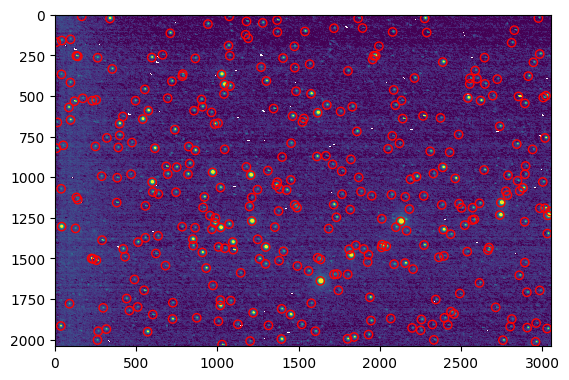

In [35]:
plt.imshow(template, cmap= "viridis", norm= LogNorm(vmin=1, vmax = 60))
for source in extracted_phot:
    plt.scatter(source['x'], source['y'], facecolors = 'none', edgecolors = 'r')

plt.savefig("F:/SDI/template.png", dpi = 400)
